InceptionV3 for Cats vs Dogs Classification

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
# from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from matplotlib import image as im
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from google.colab import drive

Mount Google Drive

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


Download & explore data: Retreving data from the source

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/training.zip' /content 
!cp '/content/drive/MyDrive/Colab Notebooks/testing.zip' /content
!unzip '/content/training.zip'
!unzip '/content/testing.zip'

Download & explore data: Structuring the path for datasets and on the last line is for the resizing of the images

In [4]:
train_path="/content/training" #define the variable for training data
test_path="/content/testing" #define the variable for testing data
validation_path = "/content/validation" #define the variable for validating data
os.mkdir(validation_path) #create a directory in os module in Python
os.mkdir(validation_path + '/cat') #create a directory in os module in Python validating>cat
os.mkdir(validation_path + '/dog') #create a directory in os module in Python validating>dog
IMG_SIZE = 299 #resizing image to 299

Download & explore data: Still structuring the directory for the validation dataset

In [5]:
validation_cat = round(len(os.listdir(train_path + '/cat')) * 0.3) #os.listdir to print the files in the directory and return a rounded number which is 30% of the total number in training dataset
validation_dog = round(len(os.listdir(train_path + '/dog')) * 0.3) #os.listdir to print the files in the directory and return a rounded number which is 30% of the total number in training dataset
count = 0
for i in os.listdir(train_path + '/cat'): #recurring for cat folder
  count += 1
  shutil.move(train_path + '/cat/' + i, validation_path + '/cat/') #shutil.move is to recursive transfer files from one folder to another folder
  if count == validation_cat: #until the count is equal to the no of cat validation dataset, 30% of the training datasets
    break
count = 0 #reset count value for dog
for i in os.listdir(train_path + '/dog'): #recurring for cat folder
  count += 1
  shutil.move(train_path + '/dog/' + i, validation_path + '/dog/')
  if count == validation_dog:
    break

In [6]:
BATCH_SIZE = 100 #so this is like taking {BATCH_SIZE} from {len(train_path) to process per pipeline}..so using a batch size has its advantages vs using all training data at once
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path, #basically this loads images from the directory and returns tf.data; Load data using a Keras utility
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=(IMG_SIZE, IMG_SIZE)
                                                            )
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_path, #basically this loads images from the directory and returns tf.data
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE, IMG_SIZE)
                                                                 )
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=(IMG_SIZE, IMG_SIZE))

Found 17501 files belonging to 2 classes.
Found 7499 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Something that Kyron added to avoid overfitting

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#Early stopping to avoid overfitting of model

Download & explore data: Still at data exploration; Visualize data

['cat', 'dog']


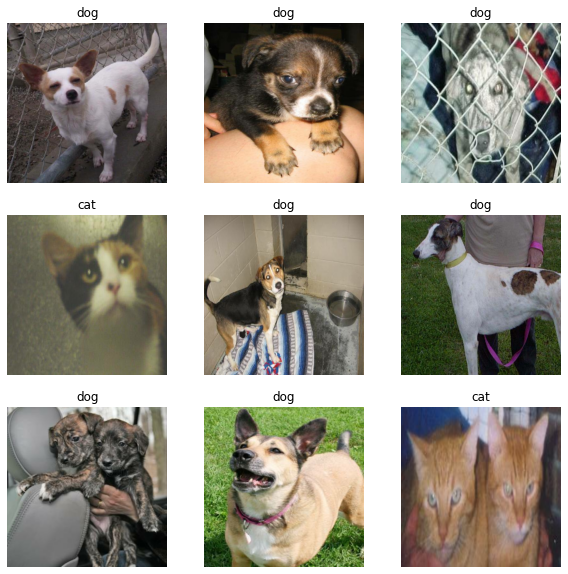

In [9]:
# Show the first nine images and labels from the training set 
class_names = train_dataset.class_names #class_names is an attribute
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Added AUTOTUNE to avoid blocking while loading the data

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

Applying the augmentation layers to the image below

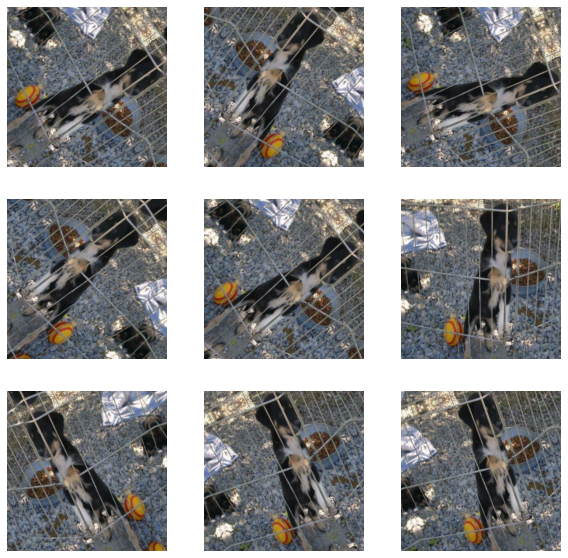

In [12]:
for image, _ in train_dataset.take(1): #why need to augment the data when the data is already many? and is the data augmentation only happens to one class?
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#rescale = tf.keras.layers.Rescaling(1./255, offset=-1) #the model values expect [-1,1] as [0,255] is not ideal for neural network. Seek small values 

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = InceptionV3(input_shape=IMG_SHAPE, #is the image shape correct for Inceptionv3? Inceptionv3 standard image size is 299x299
                        include_top=False,
                         weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(100, 8, 8, 2048)


In [15]:
base_model.trainable = False #freeze to prevent weights from being updated during training

In [16]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

Add classification head

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # to convert the features to a single 1280-element vector per image
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(100, 2048)


In [18]:
prediction_layer = tf.keras.layers.Dense(1) # to convert these features into a single prediction per image
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(100, 1)


Compile using Keras Functional API

In [19]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x) #changed to inceptionv3 preprocess_input
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) #can play around with the dropout value
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile (Actually compiling)

In [20]:
base_learning_rate = 0.0001 # try this instead 0.0002 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [22]:
len(model.trainable_variables)

2

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

Train the model

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 10s 381ms/step - loss: 0.8920 - accuracy: 0.4760
initial loss: 0.89
initial accuracy: 0.48


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset
                    )

Epoch 1/10
176/176 [==============================] - 134s 734ms/step - loss: 0.5501 - accuracy: 0.6668 - val_loss: 0.3073 - val_accuracy: 0.8875
Epoch 2/10
176/176 [==============================] - 127s 715ms/step - loss: 0.2600 - accuracy: 0.9203 - val_loss: 0.1689 - val_accuracy: 0.9701
Epoch 3/10
176/176 [==============================] - 130s 733ms/step - loss: 0.1727 - accuracy: 0.9585 - val_loss: 0.1167 - val_accuracy: 0.9833
Epoch 4/10
176/176 [==============================] - 127s 717ms/step - loss: 0.1352 - accuracy: 0.9678 - val_loss: 0.0909 - val_accuracy: 0.9876
Epoch 5/10
176/176 [==============================] - 130s 726ms/step - loss: 0.1111 - accuracy: 0.9716 - val_loss: 0.0739 - val_accuracy: 0.9899
Epoch 6/10
176/176 [==============================] - 128s 724ms/step - loss: 0.0983 - accuracy: 0.9747 - val_loss: 0.0643 - val_accuracy: 0.9907
Epoch 7/10
176/176 [==============================] - 128s 722ms/step - loss: 0.0890 - accuracy: 0.9755 - val_loss: 0.0566 -

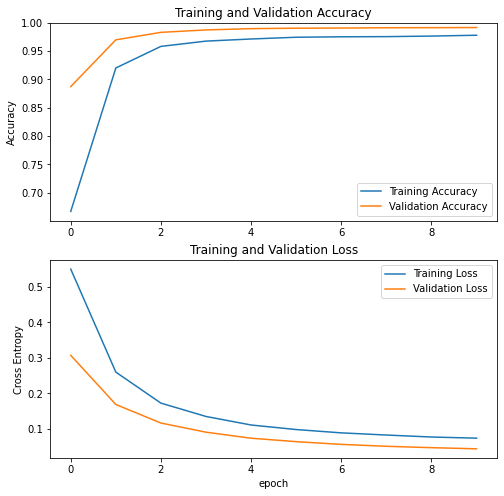

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
accuracy_score = model.evaluate(test_dataset)

print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))

10/10 [==============================] - 6s 423ms/step - loss: 0.0476 - accuracy: 0.9960
Accuracy: 99.60%


Labels:
 [1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0
 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1
 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0]


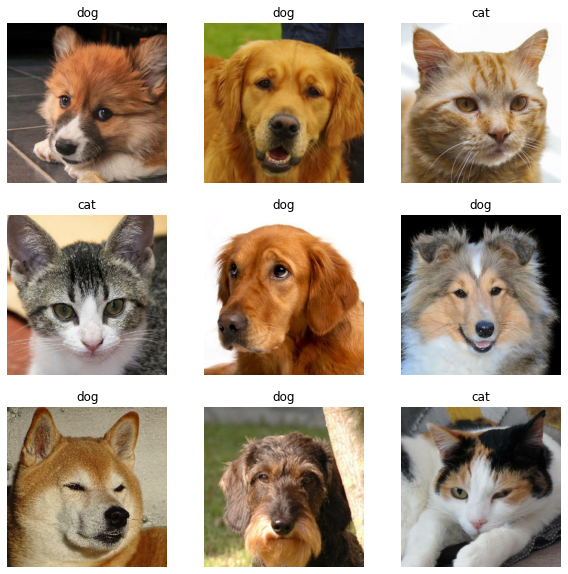

In [27]:
# # Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# img_path = 'Cat03.jpg'
# # img_path = 'predict_dog.jpg'
# img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
# data = plt.imread(img_path)
# plt.imshow(data)
# plt.show()
# x = tf.keras.utils.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# preds=  model.predict(x)
# if(preds[0] >= 0.5):
#   pet = "Dog"
# else:
#   pet = "Cat"
# print(preds[0])
# print("Predicted Animal: " + pet)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

[3.3066713e-04 9.3564463e-01 2.8225484e-03 2.3231979e-03 9.3878256e-03
 9.7386634e-01 3.7942918e-03 6.9428992e-04 8.0574089e-01 1.8273758e-03
 6.8545582e-05 4.4079529e-04 5.4551340e-03 9.4415832e-01 9.9025261e-01
 9.6683623e-03 3.8069259e-02 9.4021249e-01 9.9177331e-01 9.7895598e-01
 1.2645611e-03 9.2315298e-01 2.3844934e-03 8.8891327e-01 5.8426138e-04
 4.0377551e-03 7.5950479e-04 9.8889017e-01 5.2995617e-03 4.6977422e-01
 2.5646824e-03 9.8933882e-01 9.0425771e-01 5.2989433e-03 9.8796695e-01
 9.8941457e-01 9.6300739e-01 8.2792991e-01 9.9468404e-01 9.9569327e-01
 9.4807720e-01 9.4540054e-01 1.9539774e-03 5.6880615e-03 1.5162736e-03
 9.9102998e-01 9.8105592e-01 9.8995346e-01 9.9588203e-01 1.1240734e-03
 9.7529513e-01 6.8614217e-03 9.4437474e-01 9.3932438e-04 9.7685826e-01
 5.5847270e-03 1.1387270e-02 1.9184796e-03 3.9193212e-04 5.7329745e-03
 3.2642651e-02 9.9463528e-01 9.8054850e-01 9.4999933e-01]


In [28]:
for i in os.listdir('/content/'):
  if i.startswith('Cat'):
    img_path = i
    # img_path = 'predict_dog.jpg'
    img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
    data = plt.imread(img_path)
    plt.imshow(data)
    plt.show()
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds=  model.predict(x)
    if(preds[0] > 0):
      pet = "Dog"
    else:
      pet = "Cat"
    print(preds[0])
    print("Predicted Animal: " + pet)

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/output-20221206T065547Z-001.zip' /content 

!unzip '/content/output-20221206T065547Z-001.zip'


In [29]:
for i in range(1, 28):
  img_path = 'output/train-' + str(i) + '.png'
  # img_path = 'predict_dog.jpg'
  img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
  data = plt.imread(img_path)
  plt.imshow(data)
  plt.show()
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds=  model.predict(x)
  if(preds[0] > 0):
    pet = "Dog"
  else:
    pet = "Cat"
  print(preds[0])
  print("Predicted Animal: " + pet)

FileNotFoundError: ignored

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

37

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/20
274/274 [==============================] - 153s 528ms/step - loss: 0.0485 - accuracy: 0.9823 - val_loss: 0.0166 - val_accuracy: 0.9941
Epoch 16/20
274/274 [==============================] - 142s 511ms/step - loss: 0.0389 - accuracy: 0.9855 - val_loss: 0.0175 - val_accuracy: 0.9940
Epoch 17/20
274/274 [==============================] - 141s 511ms/step - loss: 0.0340 - accuracy: 0.9877 - val_loss: 0.0147 - val_accuracy: 0.9945
Epoch 18/20
274/274 [==============================] - 140s 510ms/step - loss: 0.0307 - accuracy: 0.9891 - val_loss: 0.0213 - val_accuracy: 0.9928
Epoch 19/20
274/274 [==============================] - 140s 508ms/step - loss: 0.0261 - accuracy: 0.9909 - val_loss: 0.0149 - val_accuracy: 0.9947
Epoch 20/20
274/274 [==============================] - 139s 506ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.0183 - val_accuracy: 0.9939


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

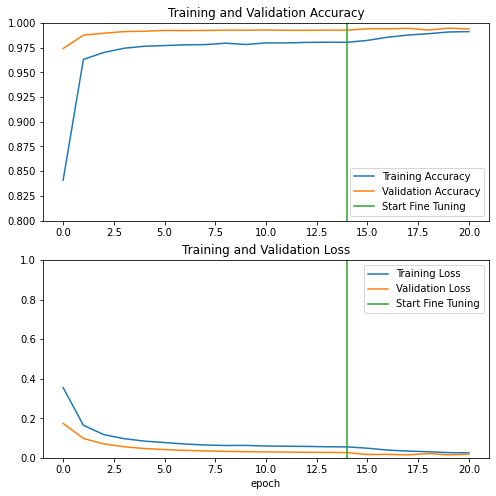

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

16/16 [==============================] - 6s 281ms/step - loss: 0.0011 - accuracy: 1.0000
Test accuracy : 1.0


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Predictions:
 [1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0]
Labels:
 [1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0]


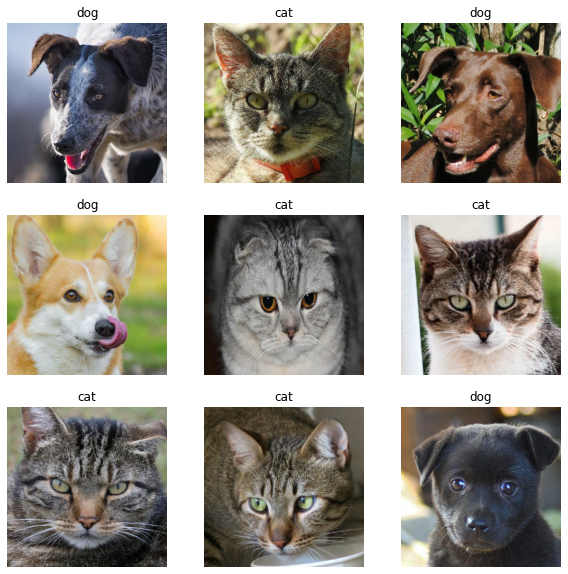

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# print(predictions)
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
# print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
# print(predictions)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

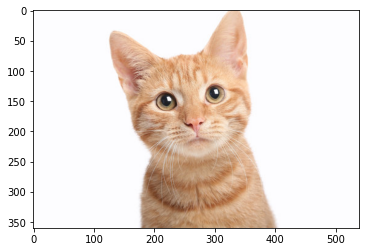

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F8BA22380D0>
1/1 [==============================] - 0s 128ms/step
[[0.5334149]]
tf.Tensor([[0.63027924]], shape=(1, 1), dtype=float32)


'dog'

In [ ]:
img_path = 'cat.jpg'
# img_path = 'predict_dog.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(299, 299))
data = plt.imread(img_path)
plt.imshow(data)
plt.show()
x = tf.keras.utils.img_to_array(img)
print(img)
x /= 255.
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds=  model.predict(x)
# if(preds[0] > 0):
#   pet = "Dog"
# else:
#   pet = "Cat"
# print(preds[0])
# print("Predicted Animal: " + pet)
# print(preds)

predictions = tf.nn.sigmoid(preds)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
# print(predictions)
class_names[predictions[0][0]]